# TM10007 Assignment template

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [37]:
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import percentile
from worcliver.load_data import load_data
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.linear_model import LogisticRegression, Lasso 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.pipeline import Pipeline
from sklearn import svm
from scipy.stats import normaltest
from sklearn.decomposition import PCA
import statistics




The number of samples: 186
The number of features: 493
The number of malignant samples: 94
The number of benign samples: 92


[Text(0.5, 1.0, 'Voorbeeld grafiek om te inspecteren hoe de data is verdeeld')]

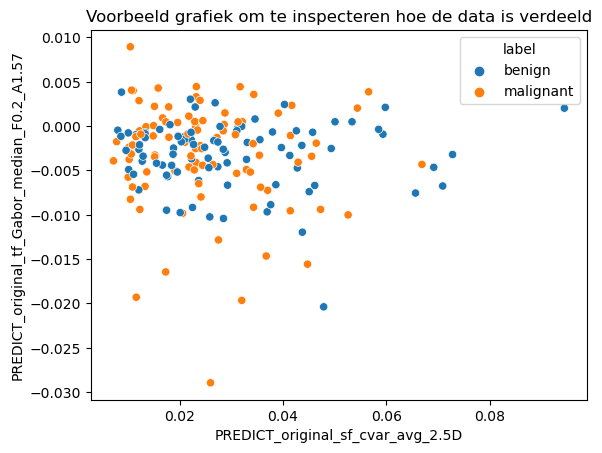

In [38]:
data = load_data()

# De label kolom even uit de dataset halen
X = data.drop('label', axis=1)   # drop the label category
y = data['label']                # Target variable die we proberen te voorspellen met het algoritme

# Make a list of feature names
feature_names = list(X.columns)

n_samples = len(data.index)
n_features = len(X.columns)
print(f'The number of samples: {n_samples}')
print(f'The number of features: {n_features}')

n_malignant = len(y[y=='malignant'])
n_benign = len(y[y=='benign'])
print(f'The number of malignant samples: {n_malignant}')
print(f"The number of benign samples: {n_benign}")

sb.scatterplot(x =feature_names[8], y = feature_names[340], data=data, hue= "label").set(title="Voorbeeld grafiek om te inspecteren hoe de data is verdeeld")

### Deleting incomplete features and patients

In [39]:
nullen = X.eq(0.0).sum()
alle_nullen = sum(nullen)
print(f'Aantal nullen in de data: {alle_nullen}') 

patient0={}
for patients in X.index:
    zero_count1 = (X.loc[patients]==0.0).sum()
    patient0[patients]=zero_count1

print(f"Hoeveelheid nullen per patient: {patient0}")

features0={}
for features in X.columns:
    zero_count2 = (X[features]==0).sum()
    features0[features]=zero_count2

features0 = {feature: count for feature, count in features0.items() if count!=0} #om alle volledige rijen, met 0 zeros eruit te halen. Vooral voor overzicht voor onszelf. 

print(f"Hoeveelheid nullen per feature: {features0}")

cutoff_feature = 0.7*n_samples
#cutoff_sample = 0.9*n_features

X_drop = X[:]
Y_drop = y[:]

for feature, counts in features0.items():
    if counts >= cutoff_feature:
        X_drop = X_drop.drop(feature, axis=1)

# for patient, count in patient0.items():
#     if count >= cutoff_sample:
#         X_drop = X_drop.drop(patient, axis=0)
#         Y_drop = Y_drop.drop(patient, axis=0)
            
print(f"Dimensies dataframe na verwijderen unrelevant features {X_drop.shape}")



Aantal nullen in de data: 4341
Hoeveelheid nullen per patient: {'Liver-001_0': 25, 'Liver-002_0': 22, 'Liver-003_0': 22, 'Liver-004_0': 25, 'Liver-005_0': 22, 'Liver-006_0': 22, 'Liver-007_0': 25, 'Liver-008_0': 23, 'Liver-009_0': 25, 'Liver-010_0': 21, 'Liver-011_0': 25, 'Liver-012_0': 25, 'Liver-013_0': 24, 'Liver-014_0': 24, 'Liver-015_0': 23, 'Liver-016_0': 24, 'Liver-017_0': 22, 'Liver-018_0': 15, 'Liver-019_0': 22, 'Liver-020_0': 24, 'Liver-021_0': 22, 'Liver-022_0': 23, 'Liver-023_0': 25, 'Liver-024_0': 24, 'Liver-025_0': 27, 'Liver-026_0': 24, 'Liver-027_0': 24, 'Liver-028_0': 23, 'Liver-029_0': 23, 'Liver-030_0': 24, 'Liver-031_0': 24, 'Liver-032_0': 23, 'Liver-033_0': 24, 'Liver-034_0': 24, 'Liver-035_0': 23, 'Liver-036_0': 27, 'Liver-037_0': 24, 'Liver-038_0': 25, 'Liver-039_0': 24, 'Liver-040_0': 24, 'Liver-041_0': 18, 'Liver-042_0': 21, 'Liver-043_0': 26, 'Liver-044_0': 21, 'Liver-045_0': 24, 'Liver-046_0': 24, 'Liver-047_0': 25, 'Liver-048_0': 22, 'Liver-049_0': 25, 'Live

### Check normality

In [40]:
## Normality check
# P-waarde berekenen voor elke feature (statistiek test om te testen of H0: Data is normaal verdeeld)
p_values = []
for features in X_drop.columns:
    _, p = normaltest(X[features])
    p_values.append(p)

for i, features in enumerate(X_drop.columns):
    print("Variable:", features)
    print("p-value:", p_values[i])
    if p_values[i] < 0.05:
        print("The variable is not normally distributed")
    else:
        print("The variable is normally distributed")

c:\Users\lotte\miniconda3\lib\site-packages\scipy\stats\_stats_py.py:1670: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = skew(a, axis)
c:\Users\lotte\miniconda3\lib\site-packages\scipy\stats\_stats_py.py:1774: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  b2 = kurtosis(a, axis, fisher=False)


Variable: PREDICT_original_sf_compactness_avg_2.5D
p-value: 1.145662534663526e-10
The variable is not normally distributed
Variable: PREDICT_original_sf_compactness_std_2.5D
p-value: 5.082112458342082e-16
The variable is not normally distributed
Variable: PREDICT_original_sf_rad_dist_avg_2.5D
p-value: 4.280298135711637e-06
The variable is not normally distributed
Variable: PREDICT_original_sf_rad_dist_std_2.5D
p-value: 2.4907255505070975e-14
The variable is not normally distributed
Variable: PREDICT_original_sf_roughness_avg_2.5D
p-value: 3.0991062140741755e-09
The variable is not normally distributed
Variable: PREDICT_original_sf_roughness_std_2.5D
p-value: 3.467791393271106e-23
The variable is not normally distributed
Variable: PREDICT_original_sf_convexity_avg_2.5D
p-value: 3.1390583766102673e-26
The variable is not normally distributed
Variable: PREDICT_original_sf_convexity_std_2.5D
p-value: 1.6120456237759444e-28
The variable is not normally distributed
Variable: PREDICT_original

## Splitting data into test and trainingset

In [41]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_drop, Y_drop, test_size=0.2, random_state=42)

print("Training set dimensies:", X_train.shape, y_train.shape)
print("Testing set dimensies:", X_test.shape, y_test.shape)


Training set dimensies: (148, 469) (148,)
Testing set dimensies: (38, 469) (38,)


VANAF HIER ALLEEN NOG MAAR DINGEN DOEN OP DE TRAININGSET!!

## Outliers


In [42]:
k = 1.5
n_outliers={}

#print(X_train.head)

X_train_out = X_train[:]
X_test_out = X_test[:]

for feature in X_train_out.columns:
    q25, q75 = percentile(X_train_out[feature], 25), percentile(X_train_out[feature], 75)
    iqr = q75 - q25
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    outliers = [x for x in X_train_out[feature] if x < lower or x > upper]
    n_outliers[feature] = len(outliers)

    if any(X_train_out[feature] < lower):
        X_train_out.loc[X_train_out[feature] < lower, feature] = lower
    if any(X_train_out[feature] > upper):
        X_train_out.loc[X_train_out[feature] > upper, feature] = upper    

    if any(X_test_out[feature] < lower):
        X_test_out.loc[X_test_out[feature] < lower, feature] = lower
    if any(X_test_out[feature] > upper):
        X_test_out.loc[X_test_out[feature] > upper, feature] = upper

print(n_outliers)
print(sum(n_outliers.values()))
print(max(n_outliers.values()))

print(X_train_out.head)

            

{'PREDICT_original_sf_compactness_avg_2.5D': 8, 'PREDICT_original_sf_compactness_std_2.5D': 15, 'PREDICT_original_sf_rad_dist_avg_2.5D': 3, 'PREDICT_original_sf_rad_dist_std_2.5D': 5, 'PREDICT_original_sf_roughness_avg_2.5D': 2, 'PREDICT_original_sf_roughness_std_2.5D': 10, 'PREDICT_original_sf_convexity_avg_2.5D': 8, 'PREDICT_original_sf_convexity_std_2.5D': 19, 'PREDICT_original_sf_cvar_avg_2.5D': 8, 'PREDICT_original_sf_cvar_std_2.5D': 13, 'PREDICT_original_sf_prax_avg_2.5D': 0, 'PREDICT_original_sf_prax_std_2.5D': 1, 'PREDICT_original_sf_evar_avg_2.5D': 2, 'PREDICT_original_sf_evar_std_2.5D': 8, 'PREDICT_original_sf_solidity_avg_2.5D': 11, 'PREDICT_original_sf_solidity_std_2.5D': 18, 'PREDICT_original_sf_area_avg_2.5D': 14, 'PREDICT_original_sf_area_max_2.5D': 12, 'PREDICT_original_sf_area_min_2.5D': 9, 'PREDICT_original_sf_area_std_2.5D': 13, 'PREDICT_original_sf_volume_2.5D': 12, 'PREDICT_original_of_theta_x': 0, 'PREDICT_original_of_theta_y': 7, 'PREDICT_original_of_theta_z': 0,

## Scaling the data

C:\Users\lotte\AppData\Local\Temp\ipykernel_30724\1827105303.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_norm['label'] = y_train.values    #alleen voor het plotten


[Text(0.5, 1.0, 'Voorbeeld grafiek om te inspecteren hoe de data is verdeeld na schalen')]

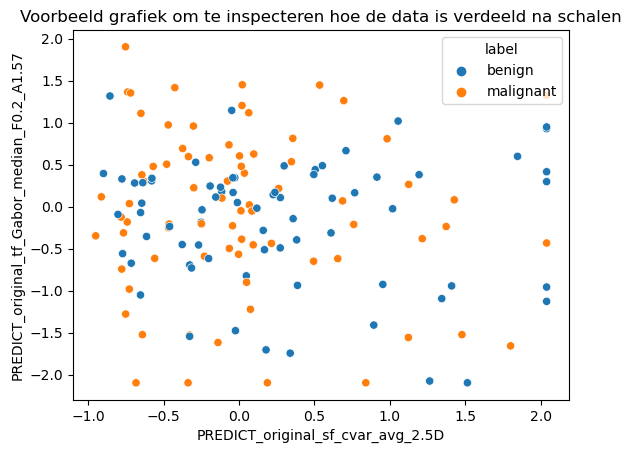

In [43]:
scaler = RobustScaler().fit(X_train_out) #Dit schaalt de data
X_train_normalized = scaler.transform(X_train_out)
X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.columns, index=X_train.index) #de normalized functie zorgt voor een numpy array, dus moet weer even teruggezet worden in een dataframe. 

#X_test_normalized = scaler.transform(X_test)
#X_test_normalized = pd.DataFrame(X_test_normalized, columns=X_test.columns)

# Plotten om te zien hoe het er nu uitziet: 
X_train_norm = X_train_normalized[:]     #alleen voor het plotten
X_train_norm['label'] = y_train.values    #alleen voor het plotten
sb.scatterplot(data=X_train_norm, x=feature_names[8], y=feature_names[340], hue='label').set(title="Voorbeeld grafiek om te inspecteren hoe de data is verdeeld na schalen")



## Feature selection > kan weg

In [44]:
# Feature selection using logistic regression
logistic = LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=7)

model = SelectFromModel(logistic)
model.fit(X_train_normalized,y_train)
#X_train_selected = model.transform(X_train_normalized)

SF = model.get_support()
X_train_features = X_train_normalized.loc[:,SF]

print(X_train_features.shape)

(148, 48)


## Dimensionality reduction > kan weg

In [45]:
pca=PCA(n_components=0.85)
X_train_pca = pca.fit_transform(X_train_features)
print(pca.n_components_)
print(X_train_pca.shape)


19
(148, 19)


## Classifier > kan weg

In [46]:
# KNN classifier

k_values = [i for i in range (1,31)]
scores = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    score = cross_val_score(knn, X_train_pca, y_train, cv=5)
    scores.append(np.mean(score))

# sb.lineplot(x = k_values, y = scores, marker = 'o')
# plt.xlabel("K Values")
# plt.ylabel("Accuracy Score")

# Random forest 

n_value = 100
random_forest = RandomForestClassifier(n_estimators=n_value)
random_forest.fit(X_train_pca, y_train)
#score = cross_val_score(random_forest, X_train_features, y_train, cv=5)
print(f'Random forest score:{np.mean(score)}')

#Linear SVC

linear_svc = svm.SVC(kernel = 'linear', C = 1.0)
linear_svc.fit(X_train_pca, y_train)
#score = cross_val_score(linear_svc, X_train_features, y_train, cv=5)
print(f'Linear SVC score: {np.mean(score)}')


Random forest score:0.750344827586207
Linear SVC score: 0.750344827586207


## Pipeline > kan weg

In [47]:
# Een voorbeeld van het gebruiken van een pipeline waarbij je meerdere parameters kan testen/optimaliseren

#hier moet C van feature selection denk ik ook nog in. 

lr = LogisticRegression(penalty='l1', solver='liblinear')

preprocessing = [('scaler', RobustScaler()),
                 ('lasso', SelectFromModel(lr)),
                 ('pca', PCA())]

pipe_knn = Pipeline(preprocessing + [('classifier', KNeighborsClassifier())])
pipe_rf = Pipeline(preprocessing + [('classifier', RandomForestClassifier())])
pipe_svc = Pipeline(preprocessing + [('classifier', svm.SVC())])

parameters_knn = {'scaler': [RobustScaler(), MinMaxScaler()], 
                  'lasso__estimator__C': [0.5, 1, 2, 3],
                  'pca__n_components': [0.8, 0.9, 0.95],  #we geven hm nu verschillende varianties om uit te kiezen. Idk of dat logisch is?
                  'classifier__n_neighbors': range(5,30),
                  'classifier__p': [1, 2],
                  #'classifier__leaf_size': [1, 5, 10, 15]
                 }

parameters_rf = {'scaler': [RobustScaler(), MinMaxScaler()], 
                 'lasso__estimator__C': [0.5, 1, 2, 3],
                 'pca__n_components': [0.8, 0.9, 0.95],
                 'classifier__n_estimators': [10, 50, 100, 150, 200],
                 'classifier__max_depth': [3, 5],
                 'classifier__min_samples_split': [5,10,15],
                 'classifier__max_features': ['sqrt','log2', None]
                }

parameters_svc = {'scaler': [RobustScaler()], 
                  'lasso__estimator__C': [0.5, 1, 2, 3],
                  'pca__n_components': [0.8, 0.9, 0.95],
                  'classifier__kernel': ['linear'],
                  'classifier__C': [0.1, 1, 10]
                 }

# Grid search waarbij je de optimale parameters gaat zoeken

classifiers = {'knn': (pipe_knn, parameters_knn),
               'Random Forest': (pipe_rf, parameters_rf),
               'SVC': (pipe_svc, parameters_svc)}

for name, (classifier, parameter) in classifiers.items():
    search = RandomizedSearchCV(classifier, parameter, cv=5, n_iter=20)
    search.fit(X_train_out, y_train)
    print(name)
    print("Best hyperparameters: ", search.best_params_)
    print('validation set score: ' + str(search.best_score_))
    #print('Training set score: ' + str(np.mean(search.cv_results_['mean_train_score'])))
    #print('Test set score: ' + str(search.score(X_test_out, y_test)))

print(search)


knn
Best hyperparameters:  {'scaler': MinMaxScaler(), 'pca__n_components': 0.95, 'lasso__estimator__C': 0.5, 'classifier__p': 1, 'classifier__n_neighbors': 26}
validation set score: 0.7629885057471264
Random Forest
Best hyperparameters:  {'scaler': MinMaxScaler(), 'pca__n_components': 0.95, 'lasso__estimator__C': 0.5, 'classifier__n_estimators': 10, 'classifier__min_samples_split': 15, 'classifier__max_features': 'log2', 'classifier__max_depth': 3}
validation set score: 0.803448275862069
SVC
Best hyperparameters:  {'scaler': RobustScaler(), 'pca__n_components': 0.95, 'lasso__estimator__C': 1, 'classifier__kernel': 'linear', 'classifier__C': 10}
validation set score: 0.7843678160919539
RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('lasso',
                                              SelectFromModel(estimator=LogisticRegression(penalty='l1',
                                                

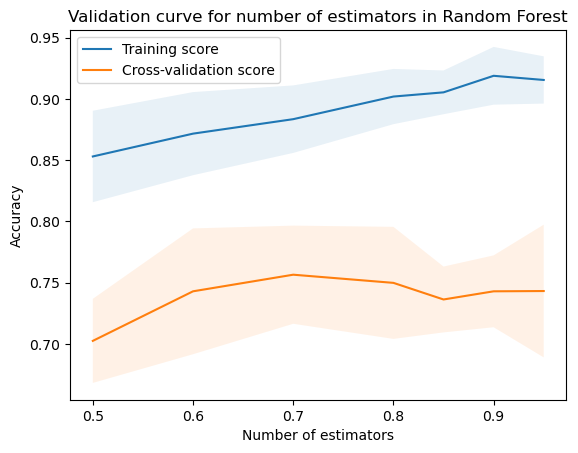

In [48]:
## validation curve Random forest

param_range = [0.5,0.6,0.7,0.8,0.85,0.9,0.95]

pipe_rf = Pipeline([('scaler', MinMaxScaler()),
                    ('lasso', SelectFromModel(LogisticRegression(C=0.5, penalty='l1', solver='liblinear'))),
                    ('pca', PCA(n_components=0.9)),
                    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=3, max_features='sqrt',min_samples_split=20))])

train_scores, validation_scores = validation_curve(
    pipe_rf, X_train_out, y_train, param_name='pca__n_components', param_range=param_range, cv=5, n_jobs=-1, scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
validation_mean = np.mean(validation_scores, axis=1)
validation_std = np.std(validation_scores, axis=1)

plt.plot(param_range, train_mean, label='Training score')
plt.plot(param_range, validation_mean, label='Cross-validation score')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(param_range, validation_mean - validation_std, validation_mean + validation_std, alpha=0.1)
plt.title('Validation curve for number of estimators in Random Forest')
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Finding hyperparameters for Lasso & PCA


In [49]:
# Pipeline: schaling is al gebeurd, KNN staat vast (default), Lasso & PCA variëren

pipe_KNN = Pipeline([('lasso', SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'))),
                    ('pca', PCA()),
                    ('classifier', KNeighborsClassifier())])

parameters = {'lasso__estimator__C': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5], 
              'pca__n_components': [0.7,0.75,0.8,0.85,0.9,0.95,0.99],
              }

search_fs = RandomizedSearchCV(pipe_KNN, parameters, cv=5, n_iter=98, return_train_score=True)
search_fs.fit(X_train_normalized, y_train)
print("Best hyperparameters: ", search_fs.best_params_)
print('validation set score: ' + str(search_fs.best_score_))

best_index = search_fs.best_index_ 
train_score = search_fs.cv_results_[f"mean_train_score"][best_index]           
validation_score = search_fs.cv_results_[f"mean_test_score"][best_index]   #ging even checken of hieruit hetzelfde kwam als best_score_ en dat klopt

print("train score: ", train_score)
print("validation score: ", validation_score)


Best hyperparameters:  {'pca__n_components': 0.8, 'lasso__estimator__C': 0.6}
validation set score: 0.7577011494252874
train score:  0.8766557470445804
validation score:  0.7577011494252874


## Choosing a classifier

In [62]:


# Feature selection

lasso_C = search_fs.best_params_['lasso__estimator__C'] 
pca_n = search_fs.best_params_['pca__n_components']

lasso_pca = [('lasso', SelectFromModel(LogisticRegression(C=lasso_C, penalty='l1', solver='liblinear'))),
             ('pca', PCA(n_components=pca_n))]

# Different classifiers

pipe_knn = Pipeline(lasso_pca + [('classifier', KNeighborsClassifier())])
pipe_rf = Pipeline(lasso_pca + [('classifier', RandomForestClassifier())])
pipe_svc = Pipeline(lasso_pca + [('classifier', svm.SVC())])

parameters_knn = {'classifier__n_neighbors': range(5,30),
                  'classifier__p': [1, 2],
                  #'classifier__leaf_size': [1, 5, 10, 15]
                 }

parameters_rf = {'classifier__n_estimators': [10, 50, 100, 150, 200],
                 'classifier__max_depth': [3, 4, 5, 6, 7],
                 'classifier__min_samples_split': [2, 4, 8, 10, 15, 20],
                 'classifier__max_features': ['sqrt','log2', None]
                }

parameters_svc = {'classifier__kernel': ['linear'],
                  'classifier__C': [0.01, 0.1, 1, 10]
                 }

classifiers = {'knn': (pipe_knn, parameters_knn),
               'Random Forest': (pipe_rf, parameters_rf),
               'SVC': (pipe_svc, parameters_svc)}

n_runs = 20
best_params_dict = {}

for name, (classifier, parameter) in classifiers.items():
     best_params_dict[name] = {"params": [], "val_scores": [], "train_scores": []}
     for i in range(n_runs):
        search = RandomizedSearchCV(classifier, parameter, cv=5, n_iter=20, return_train_score=True)
        search.fit(X_train_normalized, y_train)
        best_params_dict[name]["params"].append(search.best_params_)
        best_index = search.best_index_
        best_val_score = search.best_score_
        best_train_score = search.cv_results_[f"mean_train_score"][best_index]
        best_params_dict[name]["val_scores"].append(best_val_score)
        best_params_dict[name]["train_scores"].append(best_train_score)

means_dict = {}
for key, values in best_params_dict.items():
    val_scores = [v for v in values["val_scores"]]
    train_scores = [v for v in values["train_scores"]]
    means_dict[key] = {"mean_val_score": statistics.mean(val_scores)}
    means_dict[key]["mean_train_score"] = statistics.mean(train_scores)

print(means_dict)
print(best_params_dict)

# most_frequent_params_dict = {}
# for key, values in best_params_dict.items():
#     most_frequent_params_dict[key] = {}
#     for param_name in values[0].keys():
#         param_values = [v[param_name] for v in values if isinstance(v[param_name], (int, float))]
#         if len(param_values) > 0:
#             most_frequent_param_value = Counter(param_values).most_common(1)[0][0]
#             most_frequent_params_dict[key][param_name] = most_frequent_param_value

# print(most_frequent_params_dict)

c:\Users\lotte\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\lotte\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\lotte\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\lotte\miniconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\lotte\miniconda3\lib\site-packages\skle

{'knn': {'mean_val_score': 0.7669080459770115, 'mean_train_score': 0.8365681526848027}, 'Random Forest': {'mean_val_score': 0.7737471264367816, 'mean_train_score': 0.9929896026207093}, 'SVC': {'mean_val_score': 0.7781034482758621, 'mean_train_score': 0.9781911408631249}}
{'knn': {'params': [{'classifier__p': 1, 'classifier__n_neighbors': 21}, {'classifier__p': 1, 'classifier__n_neighbors': 20}, {'classifier__p': 1, 'classifier__n_neighbors': 29}, {'classifier__p': 2, 'classifier__n_neighbors': 6}, {'classifier__p': 1, 'classifier__n_neighbors': 29}, {'classifier__p': 1, 'classifier__n_neighbors': 19}, {'classifier__p': 1, 'classifier__n_neighbors': 21}, {'classifier__p': 2, 'classifier__n_neighbors': 6}, {'classifier__p': 1, 'classifier__n_neighbors': 21}, {'classifier__p': 1, 'classifier__n_neighbors': 21}, {'classifier__p': 1, 'classifier__n_neighbors': 20}, {'classifier__p': 1, 'classifier__n_neighbors': 29}, {'classifier__p': 1, 'classifier__n_neighbors': 21}, {'classifier__p': 1, 

## Plotjes

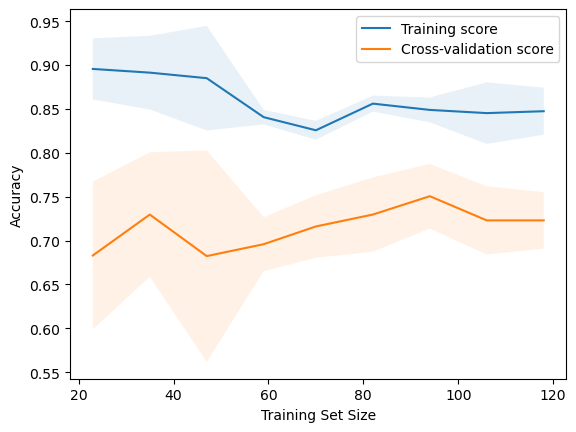

In [51]:
### Learning curves:

from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    pipe_knn, X_train_pca, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training score')
plt.plot(train_sizes, test_mean, label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


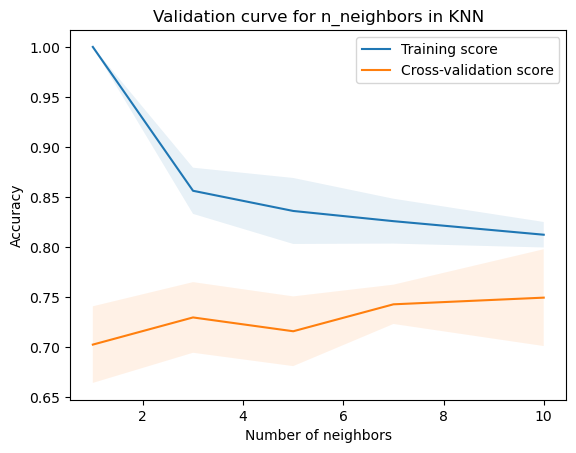

In [52]:
from sklearn.model_selection import validation_curve

## KNN for n_neighbors plot

param_range = [1, 3, 5, 7, 10]
train_scores, test_scores = validation_curve(
    pipe_knn, X_train_pca, y_train, param_name='classifier__n_neighbors', param_range=param_range, cv=5, n_jobs=-1, scoring='accuracy')

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, label='Training score')
plt.plot(param_range, test_mean, label='Cross-validation score')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.title('Validation curve for n_neighbors in KNN')
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##
